## Deep Learning Model for Hybrid EEG-Based Depression Detection with Explainable AI and API-Driven Web Integration

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import requests

# To unzip the edf_dataset
import zipfile
import os

# EDFlib and Data Preprocesing module
from mne.preprocessing import ICA, create_eog_epochs
import mne
from pyedflib import highlevel
import pyedflib as plib

In [3]:
import requests


def download_file(url, save_path):

    # Check if the file already exists
    if os.path.exists(save_path):
        print(f"File already exists at '{save_path}'. Skipping download.")
        return  # Exit the function if the file exists

    # Send a GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Open the file in binary write mode and save the content
        with open(save_path, 'wb') as file:
            file.write(response.content)
        print(f"File downloaded successfully and saved to '{save_path}'")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")


# Specify the URL and the path where you want to save the file
url = 'https://figshare.com/ndownloader/articles/4244171/versions/2'
# Change this to your desired path
save_path = './edf_dataset.zip'

# Call the function to download the file
download_file(url, save_path)

File already exists at './edf_dataset.zip'. Skipping download.


In [4]:
def unzip_file(zip_file_path, extract_to_folder):

    # Check if the directory exist
    
    if os.path.exists(extract_to_folder):
        print(f"Directory '{extract_to_folder} already exists")
        return # Exit the function if the directory
    
    # Create the directory if it doesn't exist
    os.makedirs(extract_to_folder, exist_ok=True)

    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(extract_to_folder)


# Specify the path to the zip file and the extraction folder
zip_file_path = './edf_dataset.zip'
# Change this if needed
extract_to_folder = './edf_dataset_2'

# Call the function to unzip
unzip_file(zip_file_path, extract_to_folder)


Directory './edf_dataset_2 already exists


In [5]:
import os
import re  # Import the regular expressions module

# edf_directory
edf_directory = "./edf_dataset_2"
# Loop through all files in the specified directory
for filename in os.listdir(edf_directory):
    # Check if the filename contains spaces
    if ' ' in filename:
        # Create a new filename by replacing multiple spaces with a single underscore
        # Replace one or more spaces with a single underscore
        new_filename = re.sub(r'\s+', '_', filename)

        # Get the full path for the old and new filenames
        old_file = os.path.join(edf_directory, filename)
        new_file = os.path.join(edf_directory, new_filename)

        # Rename the file
        os.rename(old_file, new_file)
        print(f'Renamed: "{filename}" to "{new_filename}"')
    elif '6931959' in filename:
        new_filename = filename.replace('6921959_', '')

        # Get the full path for the old and new filenames
        old_file = os.path.join(edf_directory, filename)
        new_file = os.path.join(edf_directory, new_filename)

        # Rename the file
        os.rename(old_file, new_file)
        print(f'Renamed: "{filename}" to "{new_filename}"')
    elif '6921143' in filename:
        new_filename = filename.replace('6921143_', '')
        # Get the full path for the old and new filenames
        old_file = os.path.join(edf_directory, filename)
        new_file = os.path.join(edf_directory, new_filename)

        # Rename the file
        os.rename(old_file, new_file)
        print(f'Renamed: "{filename}" to "{new_filename}"')
print("Renaming complete.")

Renaming complete.


In [6]:
# Function to rename channels and drop specified channels based on conditions
def process_channels(raw_data):
    """
    Process and standardize EEG channels to keep only the 17 most common channels.
    """
    print(f"Initial channels: {raw_data.ch_names}")

    # Initialize a list to hold channels to drop
    channels_to_drop = []

    # Create mapping for channel renaming
    rename_map = {}
    for name in raw_data.ch_names:
        if any(x in name for x in ['23A-23R', '24A-24R', 'A2-A1']):
            channels_to_drop.append(name)
        else:
            new_name = name.replace('EEG ', '').replace('-LE', '')
            rename_map[name] = new_name

    # Drop unwanted channels
    if channels_to_drop:
        print(f"Dropping channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Rename remaining channels
    raw_data.rename_channels(rename_map)

    print(f"Final channels: {raw_data.ch_names}")

    # Define the 17 most common channels
    expected_channels = [
        'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fp2',
        'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
    ]

    # Keep only the expected channels
    channels_to_keep = set(expected_channels)
    channels_to_drop = [
        ch for ch in raw_data.ch_names if ch not in channels_to_keep]

    if channels_to_drop:
        print(
            f"Dropping channels to keep only the expected 17 channels: {channels_to_drop}")
        raw_data.drop_channels(channels_to_drop)

    # Verify we have the expected number of channels (should be 17)
    if len(raw_data.ch_names) != len(expected_channels):
        print(
            f"Warning: Expected {len(expected_channels)} channels, got {len(raw_data.ch_names)}")
        print(f"Missing: {set(expected_channels) - set(raw_data.ch_names)}")

    return raw_data

## Data Preparation and Preprocessing

Combining dataset based on the mdd, task and stuff

In [7]:
all_edf_files = os.listdir(edf_directory)
ec_file_path = [i for i in all_edf_files if i.endswith('EC.edf')]
eo_file_path = [i for i in all_edf_files if i.endswith('EO.edf')]
task_file_path = [i for i in all_edf_files if i.endswith('TASK.edf')]

print(len(all_edf_files), len(ec_file_path), len(eo_file_path), len(task_file_path))

180 58 61 61


In [8]:
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference()
    return data
    

In [9]:
def bandpass_filter(data, l_freq, h_freq, notch_freq=None):
    filtered_data = data.copy()

    # Apply bandpass first
    filtered_data.filter(l_freq=l_freq, h_freq=h_freq,
                         method='fir', phase='zero')

    # If using notch, apply with wider bandwidth
    if notch_freq is not None:
        filtered_data.notch_filter(freqs=notch_freq, notch_widths=2.0)

    return filtered_data

In [10]:
ica_channels = ['Fp1', 'Fp2']

In [11]:
def preprocess_ICA(epochs, n_components):
    """
    Apply Independent Component Analysis (ICA) to the epochs data.
    
    Parameters:
    -----------
    epochs : mne.Epochs
        The epochs data to process.
    n_components : int
        The number of components to extract.
    
    Returns:
    --------
    ica : ICA
        The fitted ICA object.
    """
    print(
        f"Preprocessing ICA for {len(epochs)} epochs...")  # Print the number of epochs being processed

    ica = ICA(n_components=n_components, random_state=97, max_iter=800)
    # Use the epochs directly
    ica.fit(epochs.copy().pick_channels(ica_channels))
    return ica

In [12]:
def create_epochs(processed_data, duration=5.0, overlap=1.0):
    """
    Create epochs from continuous EEG data and format for CNN input
    
    Parameters:
    -----------
    processed_data : mne.io.Raw
        The raw EEG data
    duration : float
        Duration of each epoch in seconds
    overlap : float
        Overlap between epochs in seconds
    
    Returns:
    --------
    epochs_array : numpy.ndarray
        The epoched data formatted for CNN (samples, channels, timepoints, 1)
    """

    # Create epochs
    epochs = mne.make_fixed_length_epochs(
        processed_data,
        duration=duration,
        overlap=overlap,
        preload=True
    )

    # Drop bad epochs
    epochs.drop_bad()

    # Get data and reshape for CNN
    # Shape will be (n_epochs, n_channels, n_timepoints)
    data = epochs.get_data()

    # Add channel dimension for CNN: (n_epochs, n_channels, n_timepoints, 1)
    data = data[..., np.newaxis]

    return data

In [13]:
# Directory containing the EDF files
edf_directory = "./edf_dataset_2"  # Adjust this path to your dataset location

# Initialize lists
processed_raw_data = []
class_counts = {'Healthy': 0, 'MDD': 0}

# Read all EDF files
for filename in os.listdir(edf_directory):
    if filename.endswith('.edf'):
        file_path = os.path.join(edf_directory, filename)
        try:
            # Read the raw data
            raw_data = read_data(file_path)

            if raw_data is not None:
                processed_raw_data.append(raw_data)
                print(f"Successfully loaded: {filename}")
            else:
                print(f"Failed to load: {filename}")

        except Exception as e:
            print(f"Error loading {filename}: {str(e)}")
            continue

print(f"\nTotal files loaded: {len(processed_raw_data)}")

Extracting EDF parameters from /Users/hansandreanto/Development/capstone-project/edf_dataset_2/H_S4_TASK.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 154879  =      0.000 ...   604.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Successfully loaded: H_S4_TASK.edf
Extracting EDF parameters from /Users/hansandreanto/Development/capstone-project/edf_dataset_2/H_S5_TASK.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 156671  =      0.000 ...   611.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Successfully loaded: H_S5_TASK.edf
Extracting EDF parameters from /Users/hansandreanto/Development/capstone-project/edf_dataset_2/H_S16_EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 

In [17]:
def preprocess_eeg(raw_data, l_freq=0.5, h_freq=60.0, notch_freq=50.0, n_components=2, epoch_duration=5.0, epoch_overlap=1.0):
    """
    Complete EEG preprocessing pipeline: filter -> bad channel removal -> epoching -> ICA -> baseline correction
    """
    try:
        # print(f"\nProcessing file: {filename}")

        # Make a copy of the raw data to prevent modifications to original
        processed_raw = raw_data.copy()

        # 1. Bandpass filtering
        print("1. Applying bandpass filter...")
        try:
            bandpass_filter(processed_raw, l_freq, h_freq, notch_freq)
            print("Bandpass filtering completed")
        except Exception as e:
            print(f"Error during bandpass filtering: {str(e)}")
            return None

        # 2. Bad channel removal
        print("2. Removing bad channels...")
        try:
            processed_raw = process_channels(raw_data=processed_raw)
            print("Bad channels removed")
        except Exception as e:
            print(f"Error during bad channel removal: {str(e)}")
            return None

        # 3. Epoching
        print("3. Creating epochs...")
        try:
            epochs = mne.make_fixed_length_epochs(
                processed_raw,
                duration=epoch_duration,
                overlap=epoch_overlap,
                preload=True
            )

            # Drop bad epochs
            epochs.drop_bad()

            # Get data and reshape for CNN
            data = epochs.get_data()
            data = data[..., np.newaxis]  # Add channel dimension for CNN

            print(f"Epoching completed. Final data shape: {data.shape}")
        except Exception as e:
            print(f"Error during epoching: {str(e)}")
            return None

        # 4. ICA
        print("4. Applying ICA...")
        try:
            # Pass the epochs object
            ica = preprocess_ICA(epochs, n_components)
            ica.apply(epochs)  # Apply ICA to the epochs
            print("ICA completed")
        except Exception as e:
            print(f"Error during ICA: {str(e)}")
            return None

        # 5. Baseline correction
        print("5. Applying baseline correction...")
        try:
            # Apply baseline correction over the entire epoch
            epochs.apply_baseline((None, None))
            print("Baseline correction completed")
        except Exception as e:
            print(f"Error during baseline correction: {str(e)}")
            return None

        return data  # Return the processed data

    except Exception as e:
        print(f"General preprocessing error: {str(e)}")
        return None

In [18]:

# Now process each raw data file
X_data = []
y_labels = []
class_counts = {'Healthy': 0, 'MDD': 0}

print("\nStarting preprocessing pipeline...")
for raw_data in processed_raw_data:
    # Get the filename from the raw data
    filename = os.path.basename(raw_data.filenames[0])
    print(f"\n{'='*50}")
    print(f"Processing: {filename}")
    print(f"Initial data info:")
    print(f"Channels: {raw_data.ch_names}")
    print(f"Sample rate: {raw_data.info['sfreq']} Hz")
    print(f"Duration: {raw_data.n_times / raw_data.info['sfreq']:.2f} seconds")

    # Apply complete preprocessing pipeline
    try:
        # Apply complete preprocessing pipeline
        processed_data = preprocess_eeg(
            raw_data,

            l_freq=0.5,
            h_freq=50.0,
            n_components=2,
            notch_freq=50.0,
            epoch_duration=5.0,
            epoch_overlap=1.0
        )

        if processed_data is not None:
            print(f"Processed data shape: {processed_data.shape}")

            # Create label (1 for MDD, 0 for Healthy)
            label = 1 if filename.startswith('MDD') else 0

            # Update counts with number of epochs
            if label == 1:
                class_counts['MDD'] += processed_data.shape[0]
            else:
                class_counts['Healthy'] += processed_data.shape[0]

            # Append to lists
            X_data.append(processed_data)
            y_labels.extend([label] * processed_data.shape[0])
            print(f"Successfully processed {filename}")
        else:
            print(f"Failed to process {filename}")

    except Exception as e:
        print(f"Error processing {filename}: {str(e)}")
        continue

    print(f"{'='*50}\n")


# Print final summary
print("\nProcessing Summary:")
print(f"Total files processed: {len(processed_raw_data)}")
print(f"Total epochs: {len(y_labels)}")
print(f"Successfully processed files: {len(X_data)}")
print(f"Failed files: {len(processed_raw_data) - len(X_data)}")
print("\nClass distribution:")
print(f"MDD epochs: {class_counts['MDD']}")
print(f"Healthy epochs: {class_counts['Healthy']}")


Starting preprocessing pipeline...

Processing: H_S4_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter lengt

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 48.25 Hz)
- Upper passband edge: 51.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.75 Hz)
- Filter length: 1691 samples (6.605 s)

Bandpass filtering completed
2. Removing bad channels...
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.5s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S4_TASK.edf


Processing: H_S5_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 612.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed H_S5_TASK.edf


Processing: H_S16_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S16_EO.edf


Processing: MDD_S17_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S17_EC.edf


Processing: H_S13_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S13_EC.edf


Processing: MDD_S12_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 189.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 48.25 Hz)
- Upper passband edge: 51.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.75 Hz)
- Filter length: 1691 samples (6.605 s)

Bandpass filtering completed
2. Removing bad channels...
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (159, 17, 1280, 1)
Successfully processed MDD_S26_TASK.edf


Processing: MDD_S27_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 610.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, ze

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed MDD_S27_TASK.edf


Processing: H_S25_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S25_EC.edf


Processing: MDD_S24_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Epoching completed. Final data shape: (74, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 74 epochs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S24_EO.edf


Processing: MDD_S33_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S33_EC.edf


Processing: H_S20_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 320.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (79, 17, 1280, 1)
Successfully processed H_S20_EO.edf


Processing: MDD_S18_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 636.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. Final data shape: (158, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 158 epochs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S18_TASK.edf


Processing: H_S29_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'E

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S29_EC.edf


Processing: MDD_S19_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 636.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S19_TASK.edf


Processing: MDD_S21_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S21_EC.edf


Processing: MDD_S28_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S28_EO.edf


Processing: H_S6_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S6_EO.edf


Processing: MDD_S12_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 649.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (162, 17, 1280, 1)
Successfully processed MDD_S12_TASK.edf


Processing: MDD_S13_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S13_TASK.edf


Processing: MDD_S7_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S7_EC.edf


Processing: MDD_S2_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Epoching completed. Final data shape: (74, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 74 epochs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S2_EO.edf


Processing: H_S3_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-L

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S3_EC.edf


Processing: MDD_S31_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. Final data shape: (158, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 158 epochs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S31_TASK.edf


Processing: MDD_S30_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE'

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S30_TASK.edf


Processing: H_S29_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S29_TASK.edf


Processing: H_S28_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 607.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S28_TASK.edf


Processing: MDD_S1_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S1_TASK.edf


Processing: H_S1_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S1_EC.edf


Processing: H_S8_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S8_EO.edf


Processing: MDD_S9_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S9_EC.edf


Processing: H_S17_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S17_TASK.edf


Processing: H_S16_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 634.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed H_S16_TASK.edf


Processing: MDD_S5_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S5_EC.edf


Processing: H_S4_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 295.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (73, 17, 1280, 1)
Successfully processed H_S4_EO.edf


Processing: H_S11_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wind

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S11_EC.edf


Processing: H_S18_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S18_EO.edf


Processing: MDD_S10_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S10_EO.edf


Processing: MDD_S19_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S19_EC.edf


Processing: H_S23_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 620.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (154, 17, 1280, 1)
Successfully processed H_S23_TASK.edf


Processing: H_S22_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 604.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (150, 17, 1280, 1)
Successfully processed H_S22_TASK.edf


Processing: H_S14_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 194.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 48.25 Hz)
- Upper passband edge: 51.50 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.75 Hz)
- Filter length: 1691 samples (6.605 s)

Bandpass filtering completed
2. Removing bad channels...
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Dropping channels: ['EEG A2-A1']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5',

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S15_EC.edf


Processing: H_S22_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S22_EO.edf


Processing: MDD_S23_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S23_EC.edf


Processing: MDD_S34_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 296.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (73, 17, 1280, 1)
Successfully processed MDD_S34_EO.edf


Processing: H_S30_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S30_EO.edf


Processing: MDD_S31_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S31_EC.edf


Processing: H_S27_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S27_EC.edf


Processing: MDD_S26_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S26_EO.edf


Processing: MDD_S1_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


0 bad epochs dropped
Epoching completed. Final data shape: (75, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 75 epochs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S1_EC.edf


Processing: H_S9_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-L

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S9_EC.edf


Processing: MDD_S6_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 639.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (159, 17, 1280, 1)
Successfully processed MDD_S6_TASK.edf


Processing: MDD_S7_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 636.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S7_TASK.edf


Processing: H_S5_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S5_EC.edf


Processing: MDD_S4_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S4_EO.edf


Processing: H_S10_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S10_TASK.edf


Processing: H_S11_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S11_TASK.edf


Processing: MDD_S22_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S22_EO.edf


Processing: H_S23_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S23_EC.edf


Processing: MDD_S27_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S27_EC.edf


Processing: H_S26_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 305.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (76, 17, 1280, 1)
Successfully processed H_S26_EO.edf


Processing: H_S24_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 644.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (160, 17, 1280, 1)
Successfully processed H_S24_TASK.edf


Processing: H_S25_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 643.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (160, 17, 1280, 1)
Successfully processed H_S25_TASK.edf


Processing: MDD_S30_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S30_EO.edf


Processing: MDD_S11_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S11_EC.edf


Processing: MDD_S18_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S18_EO.edf


Processing: H_S10_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S10_EO.edf


Processing: H_S19_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S19_EC.edf


Processing: MDD_S14_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S14_EO.edf


Processing: H_S15_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S15_EC.edf


Processing: MDD_S32_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S32_EO.edf


Processing: MDD_S25_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S25_EC.edf


Processing: H_S24_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S24_EO.edf


Processing: H_S3_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S3_TASK.edf


Processing: H_S2_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S2_TASK.edf


Processing: MDD_S20_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S20_EO.edf


Processing: MDD_S29_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S29_EC.edf


Processing: MDD_S21_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S21_TASK.edf


Processing: MDD_S20_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S20_TASK.edf


Processing: H_S21_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S21_EC.edf


Processing: H_S28_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S28_EO.edf


Processing: MDD_S16_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S16_EO.edf


Processing: H_S17_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 309.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (77, 17, 1280, 1)
Successfully processed H_S17_EC.edf


Processing: MDD_S13_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S13_EC.edf


Processing: H_S12_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S12_EO.edf


Processing: MDD_S6_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fir

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S6_EO.edf


Processing: H_S7_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 356.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (88, 17, 1280, 1)
Successfully processed H_S7_EC.edf


Processing: H_S9_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 601.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (150, 17, 1280, 1)
Successfully processed H_S9_TASK.edf


Processing: H_S8_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 609.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed H_S8_TASK.edf


Processing: H_S2_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fir

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S2_EO.edf


Processing: MDD_S3_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 180.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (44, 17, 1280, 1)
Successfully processed MDD_S3_EC.edf


Processing: MDD_S15_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 627.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (156, 17, 1280, 1)
Successfully processed MDD_S15_TASK.edf


Processing: MDD_S14_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 635.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S14_TASK.edf


Processing: MDD_S8_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 607.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filte

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed MDD_S8_TASK.edf


Processing: MDD_S6_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S6_EC.edf


Processing: H_S7_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S7_EO.edf


Processing: H_S2_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S2_EC.edf


Processing: MDD_S3_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S3_EO.edf


Processing: MDD_S32_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S32_EC.edf


Processing: MDD_S32_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 628.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (156, 17, 1280, 1)
Successfully processed MDD_S32_TASK.edf


Processing: MDD_S33_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 658.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (164, 17, 1280, 1)
Successfully processed MDD_S33_TASK.edf


Processing: MDD_S25_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S25_EO.edf


Processing: H_S24_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S24_EC.edf


Processing: MDD_S20_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S20_EC.edf


Processing: MDD_S29_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S29_EO.edf


Processing: H_S21_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 305.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (76, 17, 1280, 1)
Successfully processed H_S21_EO.edf


Processing: H_S28_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S28_EC.edf


Processing: MDD_S2_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 644.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (160, 17, 1280, 1)
Successfully processed MDD_S2_TASK.edf


Processing: MDD_S3_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


0 bad epochs dropped
Epoching completed. Final data shape: (157, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 157 epochs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Fitting ICA to data using 2 channels (please be patient, this may take a while)
Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S3_TASK.edf


Processing: H_S17_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EE

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S17_EO.edf


Processing: H_S14_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 607.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S14_TASK.edf


Processing: H_S15_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 610.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed H_S15_TASK.edf


Processing: MDD_S13_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 311.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (77, 17, 1280, 1)
Successfully processed MDD_S13_EO.edf


Processing: MDD_S22_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S22_EC.edf


Processing: H_S23_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S23_EO.edf


Processing: MDD_S27_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S27_EO.edf


Processing: H_S26_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S26_EC.edf


Processing: MDD_S30_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 241.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (60, 17, 1280, 1)
Successfully processed MDD_S30_EC.edf


Processing: MDD_S11_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S11_EO.edf


Processing: MDD_S18_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S18_EC.edf


Processing: MDD_S11_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 637.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (159, 17, 1280, 1)
Successfully processed MDD_S11_TASK.edf


Processing: MDD_S10_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 686.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (171, 17, 1280, 1)
Successfully processed MDD_S10_TASK.edf


Processing: H_S10_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 376.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (93, 17, 1280, 1)
Successfully processed H_S10_EC.edf


Processing: H_S19_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S19_EO.edf


Processing: MDD_S14_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S14_EC.edf


Processing: H_S15_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S15_EO.edf


Processing: H_S7_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S7_TASK.edf


Processing: H_S6_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 611.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed H_S6_TASK.edf


Processing: MDD_S1_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S1_EO.edf


Processing: H_S9_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Win

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S9_EO.edf


Processing: H_S5_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 312.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (77, 17, 1280, 1)
Successfully processed H_S5_EO.edf


Processing: MDD_S25_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 628.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-pha

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (156, 17, 1280, 1)
Successfully processed MDD_S25_TASK.edf


Processing: MDD_S24_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S24_TASK.edf


Processing: H_S30_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed H_S30_TASK.edf


Processing: H_S11_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-pha

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Bandpass filtering completed
2. Removing bad channels...
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
Bad channels removed
3. Creating epochs...
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 1280 original time points ...
0 bad epochs dropped
Epoching completed. Final data shape: (75, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 75 epochs...
NOTE: pi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S11_EO.edf


Processing: MDD_S28_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S28_TASK.edf


Processing: MDD_S10_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S10_EC.edf


Processing: MDD_S29_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S29_TASK.edf


Processing: MDD_S19_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S19_EO.edf


Processing: H_S14_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S14_EC.edf


Processing: MDD_S15_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S15_EO.edf


Processing: H_S22_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S22_EC.edf


Processing: MDD_S23_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 307.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (76, 17, 1280, 1)
Successfully processed MDD_S23_EO.edf


Processing: MDD_S16_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 638.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (159, 17, 1280, 1)
Successfully processed MDD_S16_TASK.edf


Processing: MDD_S17_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 631.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S17_TASK.edf


Processing: MDD_S34_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 298.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S34_EC.edf


Processing: H_S30_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S30_EC.edf


Processing: MDD_S31_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S31_EO.edf


Processing: H_S27_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed H_S27_EO.edf


Processing: MDD_S26_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S26_EC.edf


Processing: H_S1_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S1_TASK.edf


Processing: MDD_S22_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 641.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (160, 17, 1280, 1)
Successfully processed MDD_S22_TASK.edf


Processing: MDD_S23_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 632.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (157, 17, 1280, 1)
Successfully processed MDD_S23_TASK.edf


Processing: H_S1_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 351.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (87, 17, 1280, 1)
Successfully processed H_S1_EO.edf


Processing: H_S8_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S8_EC.edf


Processing: MDD_S9_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S9_EO.edf


Processing: MDD_S5_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 302.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Bandpass filtering completed
2. Removing bad channels...
Initial channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Dropping channels: ['EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Final channels: ['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz']
Dropping channels to keep only the expected 17 channels: ['T5', 'Fz']
Bad channels removed
3. Creating epochs...
Not setting metadata
75 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 75 events and 1280 original time points ...
0 bad epochs dropped
Epoching completed. Final data shape: (75, 17, 1280, 1)
4. Applying ICA...
Preprocessing ICA for 75 epochs...
NOTE: pi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S4_EC.edf


Processing: H_S27_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed H_S27_TASK.edf


Processing: H_S26_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 611.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed H_S26_TASK.edf


Processing: H_S6_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S6_EC.edf


Processing: MDD_S2_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 297.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firw

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S2_EC.edf


Processing: H_S19_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 608.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S19_TASK.edf


Processing: H_S3_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 305.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.4s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (76, 17, 1280, 1)
Successfully processed H_S3_EO.edf


Processing: H_S18_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 608.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Wi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S18_TASK.edf


Processing: H_S16_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 292.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (72, 17, 1280, 1)
Successfully processed H_S16_EC.edf


Processing: MDD_S34_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 658.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (164, 17, 1280, 1)
Successfully processed MDD_S34_TASK.edf


Processing: MDD_S17_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 299.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain desig

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S17_EO.edf


Processing: H_S13_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 303.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 2 components
Fitting ICA took 0.1s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S13_EO.edf


Processing: MDD_S5_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 614.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-pha

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (153, 17, 1280, 1)
Successfully processed MDD_S5_TASK.edf


Processing: MDD_S4_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 633.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (158, 17, 1280, 1)
Successfully processed MDD_S4_TASK.edf


Processing: MDD_S24_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S24_EC.edf


Processing: H_S13_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 610.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
-

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (152, 17, 1280, 1)
Successfully processed H_S13_TASK.edf


Processing: H_S12_TASK.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 605.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (151, 17, 1280, 1)
Successfully processed H_S12_TASK.edf


Processing: MDD_S33_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 296.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (73, 17, 1280, 1)
Successfully processed MDD_S33_EO.edf


Processing: H_S20_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 307.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- W

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Selecting by number: 2 components
Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (76, 17, 1280, 1)
Successfully processed H_S20_EC.edf


Processing: H_S29_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1', 'EEG 23A-23R', 'EEG 24A-24R']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.2s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed H_S29_EO.edf


Processing: MDD_S21_EO.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 300.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (74, 17, 1280, 1)
Successfully processed MDD_S21_EO.edf


Processing: MDD_S28_EC.edf
Initial data info:
Channels: ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE', 'EEG A2-A1']
Sample rate: 256.0 Hz
Duration: 301.00 seconds
1. Applying bandpass filter...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 0.3s.
Applying ICA to Epochs instance
    Transforming to ICA space (2 components)
    Zeroing out 0 ICA components
    Projecting back using 2 PCA components
ICA completed
5. Applying baseline correction...
Applying baseline correction (mode: mean)
Baseline correction completed
Processed data shape: (75, 17, 1280, 1)
Successfully processed MDD_S28_EC.edf


Processing Summary:
Total files processed: 180
Total epochs: 18312
Successfully processed files: 180
Failed files: 0

Class distribution:
MDD epochs: 9756
Healthy epochs: 8556


In [22]:
# Check if we have any processed data
if len(X_data) > 0:
    try:
        # Print shapes before concatenation
        print("\nArray shapes before concatenation:")
        for i, arr in enumerate(X_data):
            print(f"Array {i}: shape {arr.shape}")

        # Concatenate data
        X = np.concatenate(X_data, axis=0)
        y = np.array(y_labels)

        # Print final information
        print("\nFinal Dataset Information:")
        print(f"Total samples: {len(X)}")
        print(f"Healthy samples: {class_counts['Healthy']}")
        print(f"MDD samples: {class_counts['MDD']}")
        print(f"Input shape: {X.shape}")
        print(f"Labels shape: {y.shape}")

        # Print channel information
        print(f"\nChannels used: {raw_data.ch_names}")

        # Print class balance
        total_epochs = class_counts['MDD'] + class_counts['Healthy']
        print("\nClass balance:")
        print(f"MDD: {(class_counts['MDD']/total_epochs)*100:.2f}%")
        print(f"Healthy: {(class_counts['Healthy']/total_epochs)*100:.2f}%")

    except Exception as e:
        print(f"\nError during final processing: {str(e)}")
        print("Checking individual arrays for inconsistencies...")

        # Find arrays with different shapes
        base_shape = X_data[0].shape[1:]
        for i, arr in enumerate(X_data):
            if arr.shape[1:] != base_shape:
                print(
                    f"Mismatch at index {i}: expected {base_shape}, got {arr.shape[1:]}")
else:
    print("\nNo data was successfully processed!")


Array shapes before concatenation:
Array 0: shape (151, 17, 1280, 1)
Array 1: shape (152, 17, 1280, 1)
Array 2: shape (74, 17, 1280, 1)
Array 3: shape (74, 17, 1280, 1)
Array 4: shape (74, 17, 1280, 1)
Array 5: shape (47, 17, 1280, 1)
Array 6: shape (159, 17, 1280, 1)
Array 7: shape (152, 17, 1280, 1)
Array 8: shape (75, 17, 1280, 1)
Array 9: shape (74, 17, 1280, 1)
Array 10: shape (74, 17, 1280, 1)
Array 11: shape (79, 17, 1280, 1)
Array 12: shape (158, 17, 1280, 1)
Array 13: shape (75, 17, 1280, 1)
Array 14: shape (158, 17, 1280, 1)
Array 15: shape (74, 17, 1280, 1)
Array 16: shape (75, 17, 1280, 1)
Array 17: shape (75, 17, 1280, 1)
Array 18: shape (162, 17, 1280, 1)
Array 19: shape (157, 17, 1280, 1)
Array 20: shape (74, 17, 1280, 1)
Array 21: shape (74, 17, 1280, 1)
Array 22: shape (75, 17, 1280, 1)
Array 23: shape (158, 17, 1280, 1)
Array 24: shape (157, 17, 1280, 1)
Array 25: shape (151, 17, 1280, 1)
Array 26: shape (151, 17, 1280, 1)
Array 27: shape (157, 17, 1280, 1)
Array 28:

## Initial Baseline Model

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping

# Print original shape
print("Original shape:", X.shape)  # Should be (18312, 19, 1280, 1)

learning_rate = 0.001
# Remove the extra dimension
X = X.squeeze(-1)  # Shape becomes (18312, 19, 1280)
print("Reshaped data shape:", X.shape)

# Convert labels to numpy array
y = np.array(y_labels)

# Define the CNN model
model = Sequential([
    # Input layer - Conv1D
    Conv1D(
        filters=32,
        kernel_size=11,
        activation='relu',
        padding='same',  # Add padding to prevent size issues
        input_shape=(17, 1280)
    ),

    # Second Conv1D layer
    Conv1D(
        filters=64,
        kernel_size=11,
        activation='relu',
        padding='same'  # Add padding
    ),

    # Dropout layer
    Dropout(0.2),

    # MaxPooling layer
    MaxPooling1D(pool_size=4),

    # Flatten layer
    Flatten(),

    # Dense layer
    Dense(100, activation='relu'),

    # Output layer
    Dense(1, activation='sigmoid')
])

Original shape: (18312, 17, 1280, 1)
Reshaped data shape: (18312, 17, 1280)


In [25]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nModel Architecture:")
model.summary()


Model Architecture:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 32)            450592    
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            22592     
                                                                 
 dropout (Dropout)           (None, 17, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                   

In [26]:

# early_stopping = EarlyStopping(
#     monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation split
history = model.fit(
    X, y,
    epochs=25,
    batch_size=32,
    validation_split=0.2,  # Added validation split
    # callbacks=[early_stopping],
    verbose=1
)

Epoch 1/25
458/458 [==============================] - 6s 13ms/step - loss: 0.6896 - accuracy: 0.5457 - val_loss: 0.7060 - val_accuracy: 0.4813
Epoch 2/25
458/458 [==============================] - 6s 12ms/step - loss: 0.6892 - accuracy: 0.5456 - val_loss: 0.6996 - val_accuracy: 0.4813
Epoch 3/25
458/458 [==============================] - 5s 12ms/step - loss: 0.6218 - accuracy: 0.6385 - val_loss: 0.5319 - val_accuracy: 0.7226
Epoch 4/25
458/458 [==============================] - 5s 11ms/step - loss: 0.4844 - accuracy: 0.7796 - val_loss: 0.4977 - val_accuracy: 0.7557
Epoch 5/25
458/458 [==============================] - 5s 11ms/step - loss: 0.4725 - accuracy: 0.7833 - val_loss: 0.5007 - val_accuracy: 0.7565
Epoch 6/25
458/458 [==============================] - 5s 10ms/step - loss: 0.4709 - accuracy: 0.7891 - val_loss: 0.4867 - val_accuracy: 0.7636
Epoch 7/25
458/458 [==============================] - 5s 10ms/step - loss: 0.4589 - accuracy: 0.7941 - val_loss: 0.4924 - val_accuracy: 0.7606

In [27]:
print("X_data type:", type(X_data))
print("X_data length:", len(X_data))
print("First array shape:", X_data[0].shape)
print("Concatenated X shape:", X.shape)

X_data type: <class 'list'>
X_data length: 180
First array shape: (151, 17, 1280, 1)
Concatenated X shape: (18312, 17, 1280)


In [84]:
# # Compile the model
# model.compile(
#     optimizer=Adam(learning_rate=learning_rate),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )

# # Print model summary
# print("\nModel Architecture:")
# model.summary()



Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 17, 32)         │       450,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 17, 64)         │        22,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 4, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 498,985 (1.90 MB)

 Trainable params: 498,985 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

In [85]:

# # early_stopping = EarlyStopping(
# #     monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the model with validation split
# history = model.fit(
#     X, y,
#     epochs=25,
#     batch_size=32,
#     validation_split=0.2,  # Added validation split
#     # callbacks=[early_stopping],
#     verbose=1
# )

Epoch 1/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5321 - loss: 0.6911 - val_accuracy: 0.4834 - val_loss: 0.7017
Epoch 2/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5369 - loss: 0.6907 - val_accuracy: 0.4834 - val_loss: 0.7035
Epoch 3/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6173 - loss: 0.6421 - val_accuracy: 0.7450 - val_loss: 0.5098
Epoch 4/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7800 - loss: 0.4874 - val_accuracy: 0.7390 - val_loss: 0.5106
Epoch 5/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7838 - loss: 0.4737 - val_accuracy: 0.7477 - val_loss: 0.5066
Epoch 6/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7840 - loss: 0.4669 - val_accuracy: 0.7539 - val_loss: 0.4937
Epoch 7/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7878 - loss: 0.4602 - val_accuracy: 0.7477 - val_loss: 0.5088
Epoch 8/25
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8002 - loss: 0.4474 - val_accu

In [28]:

# Evaluate the model
y_pred = (model.predict(X) > 0.5).astype(int)
acc = accuracy_score(y, y_pred)
f1 = f1_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)

print("\nModel Performance:")
print(f"Accuracy: {acc:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

573/573 [==============================] - 3s 4ms/step

Model Performance:
Accuracy: 0.84
F1-score: 0.86
Precision: 0.78
Recall: 0.98


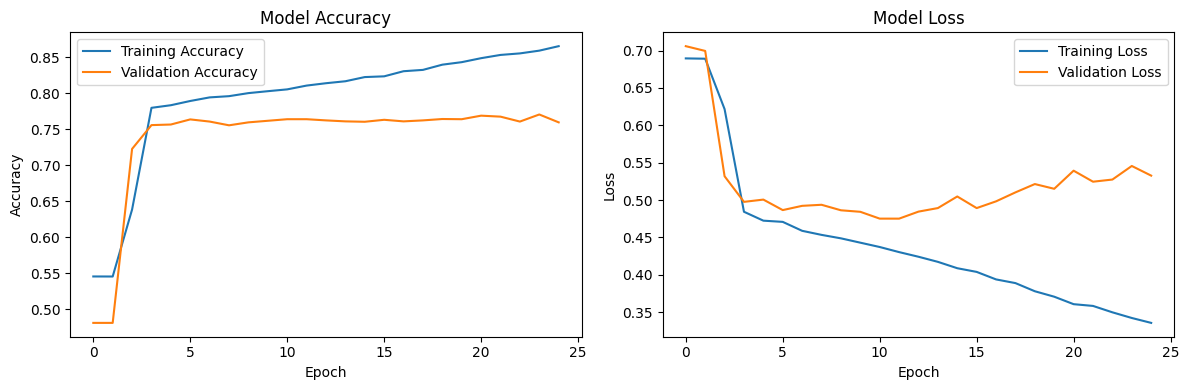

In [29]:
# Plot training history

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()

plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras.models import load_model  # Save model in SavedModel format
import tensorflow as tf
MODEL_PATH = './output/saved_model/1d_cnn/1st_model'
tf.saved_model.save(model, MODEL_PATH)
print(f"Model saved to: {MODEL_PATH}")
model = tf.keras.models.load_model(MODEL_PATH)

INFO:tensorflow:Assets written to: ./output/saved_model/1d_cnn/1st_model/assets


INFO:tensorflow:Assets written to: ./output/saved_model/1d_cnn/1st_model/assets


Model saved to: ./output/saved_model/1d_cnn/1st_model


## **LIME**

157/157 [==============================] - 1s 5ms/step


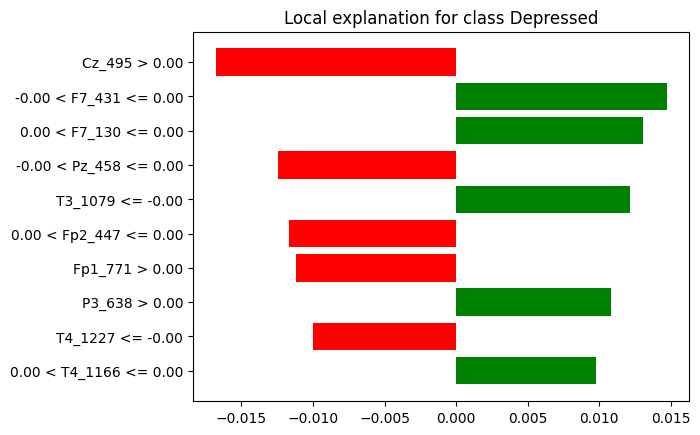

In [33]:
from sklearn.model_selection import train_test_split
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Flatten data for LIME
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define your actual channel names (replace with your specific channel labels)
channel_names = [
    'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fp2',
    'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
]

# Create feature names with proper channel and time information
feature_names = [f"{channel}_{t}" for channel in channel_names for t in range(1280)]

# Define LIME prediction wrapper
def lime_predict_proba(X):
    X_reshaped = X.reshape(X.shape[0], 17, 1280)  # Reshape back to original shape for model
    return np.hstack([1 - model.predict(X_reshaped), model.predict(X_reshaped)])

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    class_names=['Not Depressed', 'Depressed'],
    mode='classification'
)

# Explain a single instance
instance = X_test_flat[5]
explanation = explainer.explain_instance(
    data_row=instance,
    predict_fn=lime_predict_proba,
    num_features=10
)

# Visualize the explanation
explanation.show_in_notebook()

# Plot the explanation
fig = explanation.as_pyplot_figure()

# Save the figure as a PNG
fig.savefig("./output/xai/lime_explanation.png")

In [34]:
for feature, weight in explanation.as_list():
    print(f"Feature: {feature}, Weight: {weight}")


Feature: Cz_495 > 0.00, Weight: -0.016798272284851565
Feature: -0.00 < F7_431 <= 0.00, Weight: 0.014694587165832588
Feature: 0.00 < F7_130 <= 0.00, Weight: 0.01307067387430463
Feature: -0.00 < Pz_458 <= 0.00, Weight: -0.012408500442013828
Feature: T3_1079 <= -0.00, Weight: 0.012110524168495963
Feature: 0.00 < Fp2_447 <= 0.00, Weight: -0.011653752346574146
Feature: Fp1_771 > 0.00, Weight: -0.011151028811036825
Feature: P3_638 > 0.00, Weight: 0.010833863832710101
Feature: T4_1227 <= -0.00, Weight: -0.009983657353101166
Feature: 0.00 < T4_1166 <= 0.00, Weight: 0.009759730831535376


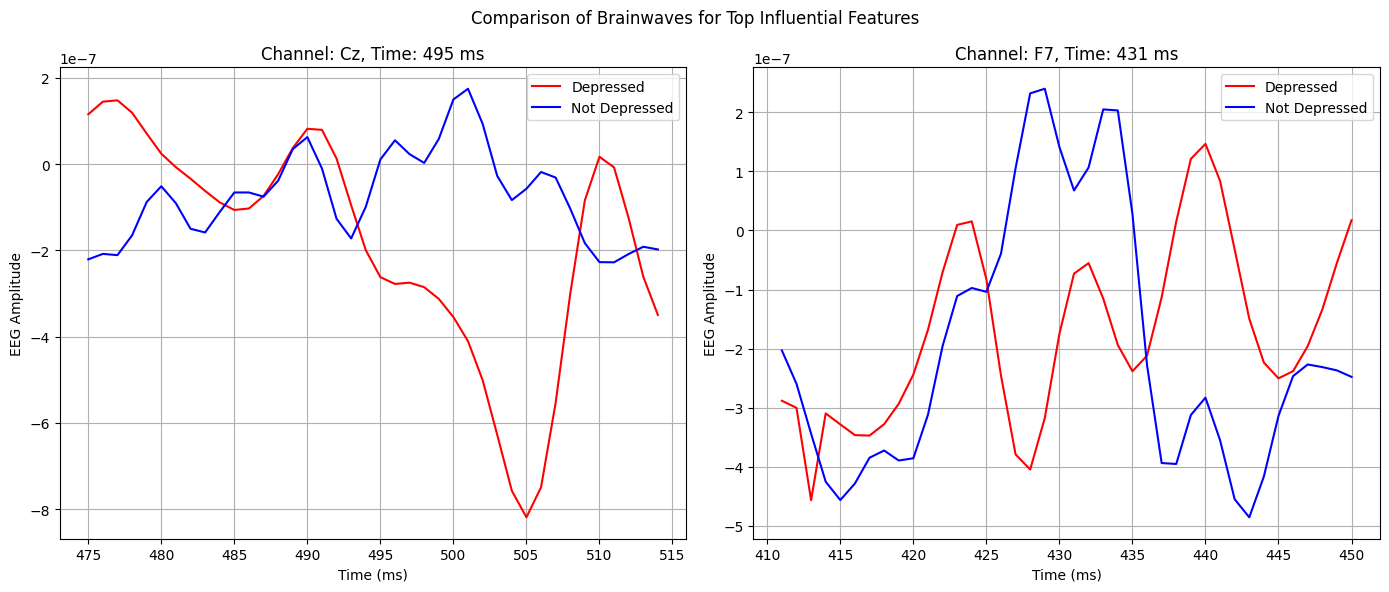

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `explanation` is the output from the LIME explainer
# `X_test` is the EEG test data shaped as (n_samples, n_channels, n_timepoints)
# `channel_names` is the list of EEG channel names

# Extract top features from the LIME explanation
def extract_top_features(explanation, top_n=2):
    top_features = explanation.as_list()[:top_n]
    feature_indices = []

    for feature, _ in top_features:
        try:
            # Extract the part containing "Channel_Time" (e.g., T4_88)
            for part in feature.split():
                if "_" in part:  # Check for "Channel_Time" format
                    channel, time_point = part.split('_')
                    feature_indices.append((channel_names.index(channel), int(time_point)))
                    break
        except (ValueError, IndexError):
            print(f"Feature {feature} could not be parsed. Skipping.")
    
    return feature_indices


# Visualization function
def plot_brainwaves(X, indices, feature_indices, title):
    plt.figure(figsize=(14, 6))
    for i, (channel_idx, time_point) in enumerate(feature_indices):
        plt.subplot(1, len(feature_indices), i + 1)

        # Extract signals for the channel around the time point
        depressed_wave = np.mean(X[indices[0], channel_idx, time_point - 20:time_point + 20], axis=0)
        not_depressed_wave = np.mean(X[indices[1], channel_idx, time_point - 20:time_point + 20], axis=0)

        # Time range for plotting
        time_range = np.arange(time_point - 20, time_point + 20)

        # Plot the signals
        plt.plot(time_range, depressed_wave, label="Depressed", color="red")
        plt.plot(time_range, not_depressed_wave, label="Not Depressed", color="blue")
        plt.title(f"Channel: {channel_names[channel_idx]}, Time: {time_point} ms")
        plt.xlabel("Time (ms)")
        plt.ylabel("EEG Amplitude")
        plt.legend()
        plt.grid()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Step 1: Extract the top features
top_feature_indices = extract_top_features(explanation, top_n=2)

# Step 2: Split the test data into depressed and not depressed groups
depressed_indices = np.where(y_test == 1)[0] 
not_depressed_indices = np.where(y_test == 0)[0]

# Step 3: Visualize the data
plot_brainwaves(
    X=X_test,
    indices=(depressed_indices, not_depressed_indices),
    feature_indices=top_feature_indices,
    title="Comparison of Brainwaves for Top Influential Features"
)


## **NeuroXAI**

First attempt: Perturbation method and calculates channel importance, which is part of NeuroXAI, but it lacks the key feature of the surrogate model (which is central to NeuroXAI’s interpretability), so this is the simple version of neuroxai.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


109/109 [==============================] - 0s 4ms/step
Ranked Channels by Importance: [16  2  1  0  3 15  7  6  4 14  8 12 13  9  5 11 10]


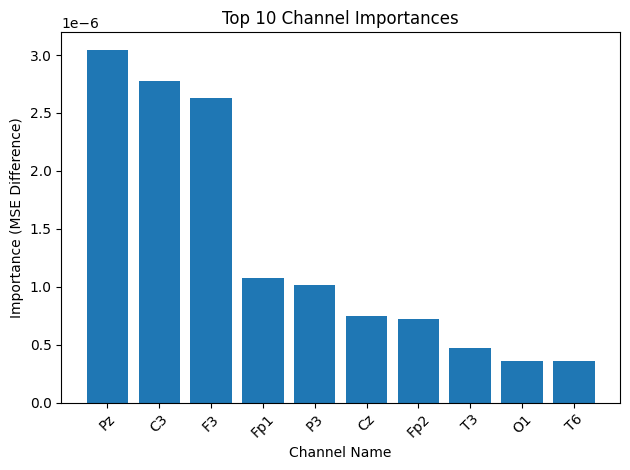

: 

In [37]:
import numpy as np
import shap
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Example EEG dataset: X_train (14709 x 17 x 1280), y_train (14709)
# Use model.predict to get predictions on original data.

# Step 1: Session Selection
def session_selector(model, X_train, threshold=0.8):
    preds = model.predict(X_train)
    high_confidence_indices = np.where(preds.max(axis=1) > threshold)[0]
    return X_train[high_confidence_indices], preds[high_confidence_indices]

X_selected, preds_selected = session_selector(model, X_train)

# Step 2: Perturbed Data Generator
def perturb_data(X, channel_idx, mode='zero'):
    perturbed = X.copy()
    if mode == 'zero':
        perturbed[:, :, channel_idx] = 0  # Replace channel with zeros
    elif mode == 'mean':
        perturbed[:, :, channel_idx] = np.mean(X[:, :, channel_idx])
    return perturbed

# Step 3: Local Surrogate Model Training
channel_importances = []
for ch in range(X_train.shape[1]):  # Loop through channels
    perturbed_data = perturb_data(X_selected, ch, mode='zero')
    pred_original = model.predict(X_selected)
    pred_perturbed = model.predict(perturbed_data)
    
    mse = mean_squared_error(pred_original, pred_perturbed)
    channel_importances.append(mse)

# Step 4: Rank Channels Globally
channel_ranking = np.argsort(channel_importances)[::-1]
print("Ranked Channels by Importance:", channel_ranking)

channel_names = [
    'Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'Fp2',
        'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz'
]

top_channel_names = [channel_names[idx] for idx in channel_ranking[:10]]

# Visualize top 10 channels
import matplotlib.pyplot as plt
plt.bar(range(10), np.array(channel_importances)[channel_ranking[:10]])
plt.xticks(range(10), top_channel_names, rotation=45)  # Replace indices with names
plt.xlabel("Channel Name")
plt.ylabel("Importance (MSE Difference)")
plt.title("Top 10 Channel Importances")
plt.tight_layout()  # Adjust layout for readability
plt.show()


**Second attempt:**

Perturbation, surrogate and then channel rankging

In [ ]:
def session_selector(model, X, y, threshold=0.8):
    """
    Select sessions with high-confidence predictions.
    """
    preds = model.predict(X)  # Predicted probabilities
    confidence_scores = np.max(preds, axis=1)  # Highest probability per sample
    selected_indices = np.where(confidence_scores >= threshold)[0]
    return X[selected_indices], y[selected_indices], preds[selected_indices]

# Apply session selection
X_selected, y_selected, preds_selected = session_selector(model, X_train, y_train)

def perturb_data(X, channel_idx, mode='zero'):
    """
    Perturb a specific channel by replacing its values.
    """
    perturbed = X.copy()
    if mode == 'zero':
        perturbed[:, channel_idx, :] = 0  # Replace channel data with zeros
    elif mode == 'noise':
        perturbed[:, channel_idx, :] = np.random.normal(0, 1, X[:, channel_idx, :].shape)
    return perturbed


from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

channel_importances = []
for ch in range(X_selected.shape[1]):  # Iterate over channels
    # Perturb the data for the current channel
    X_perturbed = perturb_data(X_selected, ch, mode='zero')
    
    # Get predictions for perturbed and original data
    preds_original = model.predict(X_selected)
    preds_perturbed = model.predict(X_perturbed)
    
    # Calculate importance based on Mean Squared Error (MSE)
    mse_diff = mean_squared_error(preds_original, preds_perturbed)
    channel_importances.append(mse_diff)

# Normalize importances
channel_importances = np.array(channel_importances) / np.max(channel_importances)

# List of channel names (replace with actual names)
channel_names = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T3", "T4", "T5", "T6", "Cz"
]

# Sort channels by importance
sorted_indices = np.argsort(channel_importances)[::-1]
sorted_importances = channel_importances[sorted_indices]
sorted_channel_names = [channel_names[i] for i in sorted_indices]

# Plot top 10 channels
plt.bar(sorted_channel_names[:10], sorted_importances[:10])
plt.xlabel("Channel Name")
plt.ylabel("Normalized Importance (MSE Difference)")
plt.title("Top 10 Channel Importances (NeuroXAI)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# yeurr


**Channels shared from both that we should be looking at cuz they're consistent: T3, Fp1, C3, F7, P3, F8**